<a href="https://colab.research.google.com/github/quirogaez/capstone/blob/main/notebooks/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **02_EDA – Procesamiento Final de Imágenes**

## Importación y cargue de imágenes

Importar librerías

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict


import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Llamar los archivos

In [3]:
# #Imagenes sin segmentar
# img_vali = '/content/drive/MyDrive/Capstone/data/pre_procesamiento/redimensionadas/redi_vali'
# img_train = '/content/drive/MyDrive/Capstone/data/pre_procesamiento/redimensionadas/redi_train'
# img_test = '/content/drive/MyDrive/Capstone/data/pre_procesamiento/redimensionadas/redi_test'

#Imagenes segmentadas
img_vali = '/content/drive/MyDrive/Capstone/data/pre_procesamiento/segmentadas_sobel/sob_vali'
img_train = '/content/drive/MyDrive/Capstone/data/pre_procesamiento/segmentadas_sobel/sob_train'
img_test = '/content/drive/MyDrive/Capstone/data/pre_procesamiento/segmentadas_sobel/sob_test'

# Ver archivos en la carpeta
df_vali = os.listdir(img_vali)
df_train = os.listdir(img_train)
df_test = os.listdir(img_test)

Función para revisión de cargue de imágenes

In [4]:
def revisar_carpeta(base_dir):
    info = {}
    total_imagenes = 0
    tamaños = defaultdict(int)

    print(f"\nRevisando: {base_dir}")
    clases = os.listdir(base_dir)
    print(f"Clases encontradas: {clases}")

    for clase in clases:
        ruta_clase = os.path.join(base_dir, clase)
        archivos = os.listdir(ruta_clase)
        total = len(archivos)
        total_imagenes += total
        info[clase] = total

        # Revisar tamaños de las primeras 5 imágenes
        for archivo in archivos[:5]:
            ruta_img = os.path.join(ruta_clase, archivo)
            img = cv2.imread(ruta_img)
            if img is not None:
                tamaños[img.shape[:2]] += 1  # Alto x Ancho

    print(f"Total imágenes: {total_imagenes}")
    print("Distribución por clase:")
    for clase, cantidad in info.items():
        print(f"  - {clase}: {cantidad} imágenes")

    print("Tamaños detectados (muestra):")
    for tamaño, cuenta in tamaños.items():
        print(f"  - {tamaño}: {cuenta} ejemplo(s)")

Aplicar función `revisar_carpeta` a cada conjunto de datos

In [5]:
# Conjunto de entrenamiento
revisar_carpeta(img_train)

# Conjunto de valdiación
revisar_carpeta(img_vali)

# Conjunto de testeo
revisar_carpeta(img_test)


Revisando: /content/drive/MyDrive/Capstone/data/pre_procesamiento/segmentadas_sobel/sob_train
Clases encontradas: ['NORMAL', 'PNEUMONIA']
Total imágenes: 5144
Distribución por clase:
  - NORMAL: 1269 imágenes
  - PNEUMONIA: 3875 imágenes
Tamaños detectados (muestra):
  - (224, 224): 10 ejemplo(s)

Revisando: /content/drive/MyDrive/Capstone/data/pre_procesamiento/segmentadas_sobel/sob_vali
Clases encontradas: ['NORMAL', 'PNEUMONIA']
Total imágenes: 16
Distribución por clase:
  - NORMAL: 8 imágenes
  - PNEUMONIA: 8 imágenes
Tamaños detectados (muestra):
  - (224, 224): 10 ejemplo(s)

Revisando: /content/drive/MyDrive/Capstone/data/pre_procesamiento/segmentadas_sobel/sob_test
Clases encontradas: ['NORMAL', 'PNEUMONIA']
Total imágenes: 624
Distribución por clase:
  - NORMAL: 234 imágenes
  - PNEUMONIA: 390 imágenes
Tamaños detectados (muestra):
  - (224, 224): 10 ejemplo(s)


Cargar datasets

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_train, # Entrenamiento
    batch_size = 32,
    label_mode = 'categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_test, # Testeo
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_vali, # Validación
    batch_size = 32,
    label_mode = 'categorical'
)

Found 5144 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


## Procesamiento final de imágenes

### Normalización

In [7]:
normalizar = lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(normalizar).prefetch(AUTOTUNE)
val_ds = val_ds.map(normalizar).prefetch(AUTOTUNE)
test_ds = test_ds.map(normalizar).prefetch(AUTOTUNE)

## Aplicación de clusterización para diferenciar la neumonía viral y bacteriana

### *Flatten* o extracción de características

In [8]:
# Extraer datos del dataset completo
class_names = ['NORMAL', 'PNEUMONIA']

def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []
    for batch in dataset:
        images, labels = batch
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    images_np = np.concatenate(images_list, axis=0)
    labels_np = np.concatenate(labels_list, axis=0)
    return images_np, labels_np

# Convertir los datos a vector
X_train, y_train = dataset_to_numpy(train_ds)

# Identificar índice de la clase "PNEUMONIA"
print("Clases:", class_names)  # ['NORMAL', 'PNEUMONIA']
indice_pneumonia = class_names.index('PNEUMONIA')

Clases: ['NORMAL', 'PNEUMONIA']


Filtrar solo las imágenes con 'PNEUMONIA'

In [9]:
mascara_pneumonia = np.argmax(y_train, axis=1) == indice_pneumonia
X_pneumonia = X_train[mascara_pneumonia]

print("Cantidad de imágenes con neumonía:", X_pneumonia.shape[0])

Cantidad de imágenes con neumonía: 3875


Flatten

In [10]:
X_pneumonia_flat = X_pneumonia.reshape(X_pneumonia.shape[0], -1)

print("Forma original:", X_pneumonia[0].shape)
print("Forma aplanada:", X_pneumonia_flat[0].shape)

Forma original: (256, 256, 3)
Forma aplanada: (196608,)


### Reducción de dimensionalidad

Iterar cantidad de componententes para dos clústeres (dos tipos de neumonía: viral y bacteriana)

In [ ]:
sil_aggl, sil_km = {}, {}

for n_comp in [5, 10, 15]:
    # 1) Reducir dimensionalidad con PCA
    pca = PCA(n_components = n_comp, random_state = 42)
    X_pca = pca.fit_transform(X_pneumonia_flat) # df

    for k in [2]:
        # 2) Clustering
        agg = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
        labels_agg = agg.fit_predict(X_pca)
        sil_aggl[(n_comp, k)] = silhouette_score(X_pca, labels_agg)

        km = KMeans(n_clusters = k, random_state = 42)
        labels_km = km.fit_predict(X_pca)
        sil_km[(n_comp, k)] = silhouette_score(X_pca, labels_km)

# Mostrar resultados
print("n_comp k   Silhouette Agglo   Silhouette KMeans")
for (n_comp, k), score in sil_aggl.items():
    print(f"{n_comp:>6} {k:>2}   {score:.4f}             {sil_km[(n_comp,k)]:.4f}")

n_comp k   Silhouette Agglo   Silhouette KMeans
     5  2   0.2073             0.2289
    10  2   0.2349             0.1688
    15  2   0.1790             0.1502


In [ ]:
sil_aggl, sil_km = {}, {}

for n_comp in [20, 50, 100]:
    # 1) Reducir dimensionalidad con PCA
    pca = PCA(n_components = n_comp, random_state = 42)
    X_pca = pca.fit_transform(X_pneumonia_flat) # df

    for k in [2]:
        # 2) Clustering
        agg = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
        labels_agg = agg.fit_predict(X_pca)
        sil_aggl[(n_comp, k)] = silhouette_score(X_pca, labels_agg)

        km = KMeans(n_clusters = k, random_state = 42)
        labels_km = km.fit_predict(X_pca)
        sil_km[(n_comp, k)] = silhouette_score(X_pca, labels_km)

# Mostrar resultados
print("n_comp k   Silhouette Agglo   Silhouette KMeans")
for (n_comp, k), score in sil_aggl.items():
    print(f"{n_comp:>6} {k:>2}   {score:.4f}             {sil_km[(n_comp,k)]:.4f}")

n_comp k   Silhouette Agglo   Silhouette KMeans
    20  2   0.1184             0.1401
    50  2   0.0939             0.1181
   100  2   0.0777             0.0983


In [ ]:
sil_aggl, sil_km = {}, {}

for n_comp in [150, 200, 250]:
    # 1) Reducir dimensionalidad con PCA
    pca = PCA(n_components = n_comp, random_state = 42)
    X_pca = pca.fit_transform(X_pneumonia_flat) # df

    for k in [2]:
        # 2) Clustering
        agg = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
        labels_agg = agg.fit_predict(X_pca)
        sil_aggl[(n_comp, k)] = silhouette_score(X_pca, labels_agg)

        km = KMeans(n_clusters = k, random_state = 42)
        labels_km = km.fit_predict(X_pca)
        sil_km[(n_comp, k)] = silhouette_score(X_pca, labels_km)

# Mostrar resultados
print("n_comp k   Silhouette Agglo   Silhouette KMeans")
for (n_comp, k), score in sil_aggl.items():
    print(f"{n_comp:>6} {k:>2}   {score:.4f}             {sil_km[(n_comp,k)]:.4f}")

n_comp k   Silhouette Agglo   Silhouette KMeans
   150  2   0.1065             0.0899
   200  2   0.0639             0.0840
   250  2   0.0616             0.0786


Reducir a $n = 5$ dimensiones

In [ ]:
pca = PCA(n_components = 5, random_state = 42)
X_pneumonia_pca = pca.fit_transform(X_pneumonia_flat)

print("Nueva forma tras PCA:", X_pneumonia_pca.shape)

Dos clústeres para los tipos de neumonía: viral y bacteriana

In [ ]:
kmeans = KMeans(n_clusters = 2, random_state = 42)
clusters = kmeans.fit_predict(X_pneumonia_pca)

### Visualizar imágenes por clústeres

In [ ]:
def mostrar_imagenes_por_cluster(imagenes, cluster_labels, cluster_id, cantidad = 10):
    indices = np.where(cluster_labels == cluster_id)[0]
    seleccionadas = np.random.choice(indices, min(cantidad, len(indices)), replace = False)

    plt.figure(figsize = (15, 6))
    for i, idx in enumerate(seleccionadas):
        plt.subplot(2, 5, i + 1)
        plt.imshow(imagenes[idx])
        plt.title(f"Cluster {cluster_id}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Mostrar imágenes del cluster 0 y 1
mostrar_imagenes_por_cluster(X_pneumonia, clusters, cluster_id = 0)
mostrar_imagenes_por_cluster(X_pneumonia, clusters, cluster_id = 1)

Visualizar clústeres por TSNE

In [ ]:
tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30)
X_pneumonia_2D = tsne.fit_transform(X_pneumonia_pca)

plt.figure(figsize = (10, 6))
plt.scatter(X_pneumonia_2D[:, 0], X_pneumonia_2D[:, 1], c = clusters, cmap='viridis', alpha = 0.6)
plt.title("Visualización t-SNE de imágenes de neumonía agrupadas por K-Means")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

### Coeficiente de Siluetta

In [ ]:
# Coeficiente de silueta promedio
silhouette_avg = silhouette_score(X_pneumonia_pca, clusters)
print(f"Coeficiente de Silueta Promedio: {silhouette_avg:.4f}")

# Coeficientes individuales de silueta
silhouette_vals = silhouette_samples(X_pneumonia_pca, clusters)

# Df para inspección
df_sil = pd.DataFrame({
    "Silhouette": silhouette_vals,
    "Cluster": clusters
})

## Histograma
plt.figure(figsize = (12, 8))
cluster_ids = np.unique(clusters)
data_by_cluster = [df_sil[df_sil["Cluster"] == cid]["Silhouette"].values
                   for cid in cluster_ids]

plt.hist(
    data_by_cluster,
    bins = 30,
    stacked = True,
    label=[f"Cluster {cid}" for cid in cluster_ids],
    alpha = 0.7,
    edgecolor = 'black'
)

plt.title("Distribución del Coeficiente de Silueta por Clúster")
plt.xlabel("Coeficiente de Silueta")
plt.ylabel("Frecuencia")
plt.legend(title = "Clúster")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

### Evaluación de clústers

In [ ]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(X_pneumonia_pca, clusters)
print(f"Davies-Bouldin Score: {db_score:.4f}")

In [ ]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X_pneumonia_pca, clusters)
print(f"Calinski-Harabasz Score: {ch_score:.4f}")

### Cantidad de imágenes por clúster

In [ ]:
# Recuentos ordenada por índice de clúster
cluster_counts = df_pca['Cluster'].value_counts().sort_index()
counts_df = cluster_counts.reset_index()
counts_df.columns = ['Cluster', 'Cant. Imágenes']; counts_df

   Cluster  Recuento
0        0      1741
1        1      2134


Visualizar con imágenes de la clase 'NORMAL'

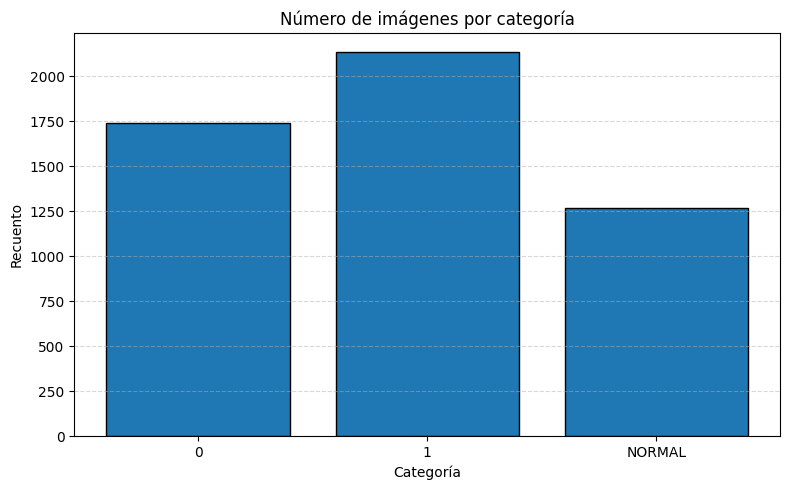

In [ ]:
# Recuento de normales
idx_normal = class_names.index('NORMAL')
normal_count = np.sum(np.argmax(y_train, axis = 1) == idx_normal)

# Partir del DataFrame de clústeres original
counts_df_plot = counts_df.copy()
counts_df_plot['Cluster'] = counts_df_plot['Cluster'].astype(str)

# DataFrame con la fila NORMAL y concatenar
normal_row = pd.DataFrame({
    'Cluster': ['NORMAL'],
    'Recuento': [normal_count]
})

counts_df_plot = pd.concat([counts_df_plot, normal_row], ignore_index=True)

# Visualizar
plt.figure(figsize = (8,5))
plt.bar(
    counts_df_plot['Cluster'],
    counts_df_plot['Recuento'],
    edgecolor = 'black'
)
plt.title("Número de imágenes por categoría")
plt.xlabel("Categoría")
plt.ylabel("Recuento")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()